In [3]:
# Alan Kaptanoglu
# 5/9/20
# This example is based off of the preprint found here https://arxiv.org/pdf/2004.10389.pdf
# and builds a data-driven model for the temporal POD modes from a plasma simulation.
# This example shows off some advanced PySINDy features that were useful for this work:
#     1. Initial guesses to the SINDy optimization object
#     2. Constrained SR3 and STLSQ algorithms 
#         (This is primarily Kathleen Champion's code, see https://arxiv.org/abs/1906.10612)
#     3. Matrix of thresholds, implemented only for constrained SR3 for now 
#         (although constrained SR3 can be used without using constraints and is equivalent to SR3).
import numpy as np
from matplotlib import pyplot as plt
from pysindy import SINDy
from pysindy.optimizers import SR3,ConstrainedSR3
from pysindy.feature_library import PolynomialLibrary,CustomLibrary
from pysindy.differentiation import FiniteDifference
from scipy.integrate import odeint

In [10]:
# plotting function for the trajectories we will model. It compares
# the performance of x (the true data), x_train (the fit on the training data)
# and x_sim (the fit on the test data)
def plot_trajectories(x,x_train,x_sim,r) :
    for i in range(r):
        plt.figure(i+1,figsize=(5,10))
        plt.subplot(r,1,i+1)
        plt.plot(time,x[:,i])
        plt.plot(t_train,x_train[:,i])
        plt.plot(t_test,x_sim[:,i])
        plt.grid(True)
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])

(-1, 30)

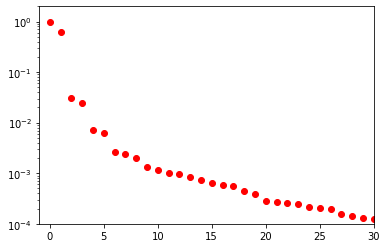

In [11]:
# load in temporal POD modes of a plasma simulation (trajectories in time)
A = np.loadtxt('data/plasmaphysics_example_trajectories.txt')
time = A[:,0]

# load in the corresponding SVD data and plot it
S = np.loadtxt('data/plasmaphysics_example_singularValues.txt')
plt.figure(1)
plt.semilogy(S/S[0],'ro')
plt.ylim(1e-4,2)
plt.xlim(-1,30)

In [23]:
# Let's run a quadratic SINDy model on the first 7 modes using the 
# unconstrainted SR3 algorithm with an initial guess. We also use a custom library.
r = 7
poly_order = 2
threshold = 0.05
tfac = 0.8  # proportion of the data to train on
M = len(time)
M_train = int(len(time)*tfac)
t_train = time[:M_train]
t_test = time[M_train:]
pod_names = []
for i in range(r):
    pod_names.append(r'a{:d}'.format(i+1))
# Normalizing the trajectories to the unit ball for simplicity
for i in range(1,r+1):
    A[:,i] = A[:,i]/sum(np.amax(abs(A),axis=0)[1:r+1])
x = A[:,1:r+1]
# Define the custom library (in this case quadratic polynomials but we want
# to exclude the constant term, the 0th order polynomial)
library_functions = [lambda x : x, lambda x,y : x*y, lambda x : x**2]
library_function_names = [lambda x : x, lambda x,y : x+y, lambda x : x+x]
# Construct the SINDy library with the custom names and SINDy terms
sindy_library = CustomLibrary(library_functions=library_functions,function_names=library_function_names)
initial_guess = np.zeros((r+int(r*(r+1)/2),r))  # Build an initial guess
initial_guess[0,1] = 0.091
initial_guess[1,0] = -0.091
initial_guess[2,3] = 0.182
initial_guess[3,2] = -0.182
initial_guess[5,4] = -3*0.091
initial_guess[4,5] = 3*0.091 
print(initial_guess)
sindy_opt = SR3(threshold=threshold,nu=1,initial_guess=initial_guess,max_iter=1000)
model = SINDy(optimizer=sindy_opt,feature_library=sindy_library, \
    differentiation_method=FiniteDifference(drop_endpoints=True),feature_names=pod_names)
x_train = x[:M_train,:]
x0_train = x[0,:]
x_true = x[M_train:,:]
x0_test = x[M_train,:]
# Fit a model on the training data
model.fit(x_train, t=t_train, unbias=False)
model.print()
# Forecast the testing data with this identified model
x_sim,output = model.simulate(x0_test,t_test,integrator=odeint, \
    stop_condition=None,full_output=True,rtol=1e-20,h0=1e-5)
# Get Xdot from the measurement data X
x_dot = model.differentiate(x, t=time)
# Predict Xdot on the training and testing data. Since the model was trained on 
# Xdot from the training data, x_dot_train is often in excellent agreement with x_dot. 
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_true)
print('Model score: %f' % model.score(x, t=time))

[[ 0.     0.091  0.     0.     0.     0.     0.   ]
 [-0.091  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.182  0.     0.     0.   ]
 [ 0.     0.    -0.182  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.273  0.   ]
 [ 0.     0.     0.     0.    -0.273  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.

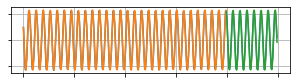

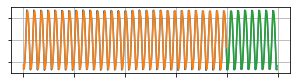

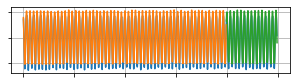

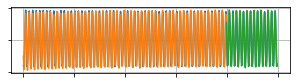

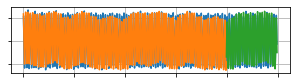

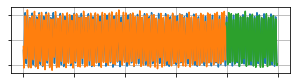

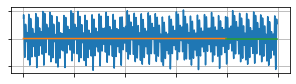

In [24]:
plot_trajectories(x_dot,x_dot_train,x_dot_sim,r)

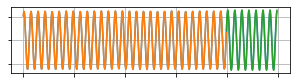

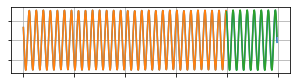

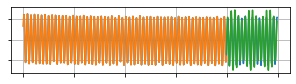

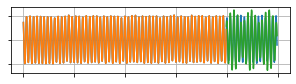

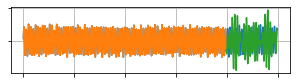

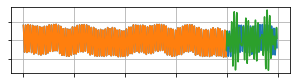

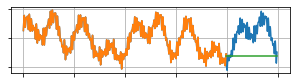

In [25]:
plot_trajectories(x,x_train,x_sim,r)

In [26]:
# Now let's run a SINDy model on the first 7 modes using the 
# constrainted SR3 algorithm with an initial guess.
# Note that this constraint is specific to the MHD model used for the provided simulation data.
threshold = 0.05
thresholder = "l0"
constraint_zeros = np.zeros(int(r*(r+1)/2))
constraint_matrix = np.zeros((int(r*(r+1)/2),int(r*(r**2+3*r)/2)))
# define the constraint
for i in range(r):
    constraint_matrix[i,i*(r+1)] = 1.0
q = r
for i in range(r):
    counter = 1
    for j in range(i+1,r):
        constraint_matrix[q,i*r+j] = 1.0
        constraint_matrix[q,i*r+j+counter*(r-1)] = 1.0
        counter = counter + 1
        q = q + 1
sindy_opt = ConstrainedSR3(threshold=threshold, nu=1, max_iter=10000, \
    constraint_lhs=constraint_matrix,constraint_rhs=constraint_zeros,tol=1e-6,initial_guess=initial_guess)
model = SINDy(optimizer=sindy_opt,feature_library=sindy_library, \
    differentiation_method=FiniteDifference(drop_endpoints=True),feature_names=pod_names)
model.fit(x_train, t=t_train, unbias=False)
model.print()
x_sim,output = model.simulate(x0_test,t_test,integrator=odeint, \
    stop_condition=None,full_output=True,rtol=1e-20,h0=1e-5)
x_dot = model.differentiate(x, t=time)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_true)
print('Model score: %f' % model.score(x, t=time))

a1' = 0.063 a2 + 0.574 a1a4 + -0.735 a2a3
a2' = -0.063 a1 + 0.156 a1a3
a3' = 0.148 a4 + 0.336 a1a2 + 0.062 a1a6
a4' = -0.148 a3
a5' = 0.232 a6 + 0.128 a1a4 + 0.432 a2a3
a6' = -0.232 a5
a7' = 0.000
Model score: 0.835078


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlie

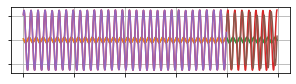

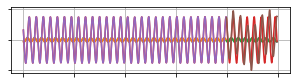

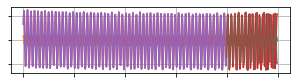

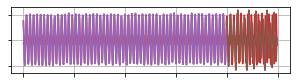

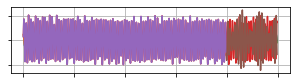

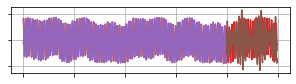

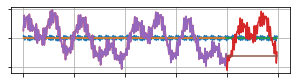

In [30]:
plot_trajectories(x_dot,x_dot_train,x_dot_sim,r)

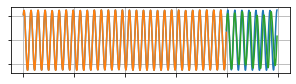

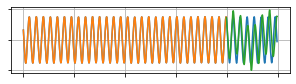

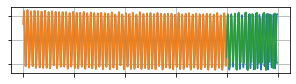

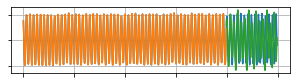

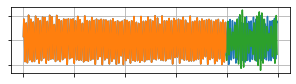

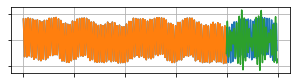

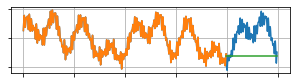

In [31]:
plot_trajectories(x,x_train,x_sim,r)

In [32]:
# Now let's run a SINDy model on the first 7 modes using the 
# constrainted SR3 algorithm with an initial guess AND variable thresholding
# First try: let's restrict only to linear terms by greatly increasing the thresholding on the quadratic terms 
tfac = 0.8
threshold = 0.05
# Need to change the thresholder to deal with the matrix of thresholds
thresholder = "weighted_l0"
thresholds = threshold*np.ones((r+int(r*(r+1)/2),r))
# Make the thresholds for the quadratic terms very large
thresholds[r:,:] = 30*threshold*np.ones(thresholds[r:,:].shape)
sindy_opt = ConstrainedSR3(threshold=threshold, nu=10, max_iter=50000, \
    constraint_lhs=constraint_matrix,constraint_rhs=constraint_zeros, \
    tol=1e-5,thresholder=thresholder,initial_guess=initial_guess,thresholds=thresholds)
model = SINDy(optimizer=sindy_opt,feature_library=sindy_library, \
    differentiation_method=FiniteDifference(drop_endpoints=True),feature_names=pod_names)
model.fit(x_train, t=t_train, unbias=False)
model.print()
x_sim,output = model.simulate(x0_test,t_test,integrator=odeint,
    stop_condition=None,full_output=True,rtol=1e-20,h0=1e-5)
x_dot = model.differentiate(x, t=time)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_true)
print('Model score: %f' % model.score(x, t=time))

a1' = 0.081 a2
a2' = -0.081 a1
a3' = 0.178 a4
a4' = -0.178 a3
a5' = 0.260 a6 + -0.053 a7
a6' = -0.260 a5
a7' = 0.053 a5
Model score: 0.592602


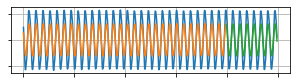

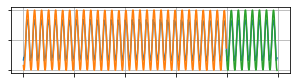

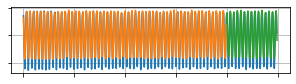

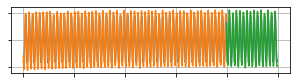

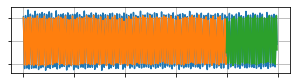

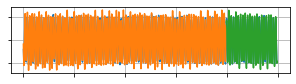

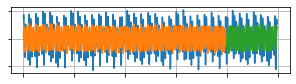

In [34]:
plot_trajectories(x_dot,x_dot_train,x_dot_sim,r)

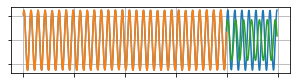

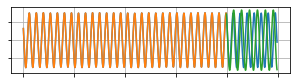

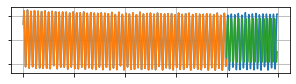

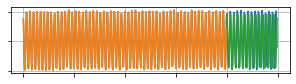

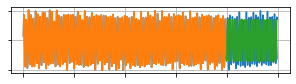

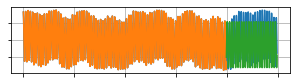

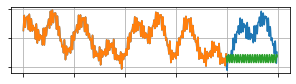

In [35]:
plot_trajectories(x,x_train,x_sim,r)

In [36]:
# Okay, so just linear terms look pretty good but have some small errors in the frequencies
# and the can't capture the 7th mode. Let's demand quadratic models for a3-a7, although there is a limit
# to the progress we can make with this set of modes (modes 1-6 are close to monochromatic
# which will make it difficult to capture frequency dependence beyond the driving frequency
# and its harmonics).
tfac = 0.8
threshold = 0.05
thresholder = "weighted_l0"
thresholds = threshold*np.ones((r+int(r*(r+1)/2),r))
# Try complicated set of thresholding (try playing around with these)
thresholds[r:,0:2] = 30*threshold*np.ones(thresholds[r:,0:2].shape)
thresholds[r:,2] = 0.2*np.ones(thresholds[r:,2].shape)
thresholds[r:,3] = 0.05*np.ones(thresholds[r:,3].shape)
thresholds[r:,4:6] = 0.03*np.ones(thresholds[r:,4:6].shape)
sindy_opt = ConstrainedSR3(threshold=threshold, nu=10, max_iter=50000, \
    constraint_lhs=constraint_matrix,constraint_rhs=constraint_zeros, \
    tol=1e-5,thresholder=thresholder, \
    initial_guess=initial_guess,thresholds=thresholds)
model = SINDy(optimizer=sindy_opt, \
    feature_library=sindy_library, \
    differentiation_method=FiniteDifference(drop_endpoints=True), \
    feature_names=pod_names)
model.fit(x_train, t=t_train, unbias=False)
model.print()
x_sim,output = model.simulate(x0_test,t_test, \
    integrator=odeint,stop_condition=None,full_output=True, \
    rtol=1e-20,h0=1e-5)
x_dot = model.differentiate(x, t=time)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_true)
print('Model score: %f' % model.score(x, t=time))

a1' = 0.082 a2
a2' = -0.082 a1
a3' = 0.204 a4
a4' = -0.204 a3 + 0.133 a1a5 + -0.152 a1a6 + -0.292 a2a5 + 0.074 a1a1 + -0.201 a2a2
a5' = 0.230 a6 + 0.105 a1a4 + 0.462 a2a3 + 0.219 a3a5 + 0.181 a3a7
a6' = -0.230 a5 + -0.326 a4a7
a7' = 0.085 a1a5 + 0.116 a1a6 + 0.107 a2a5 + -0.092 a2a6 + 0.373 a3a4 + 0.164 a3a3 + -0.326 a4a4
Model score: 0.779154


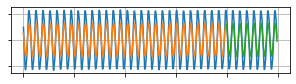

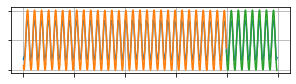

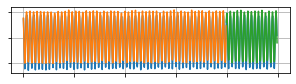

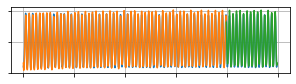

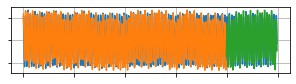

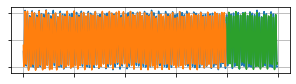

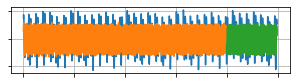

In [38]:
plot_trajectories(x_dot,x_dot_train,x_dot_sim,r)

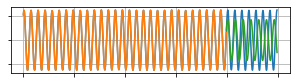

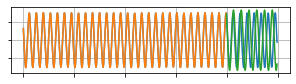

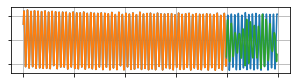

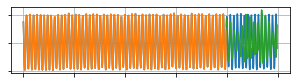

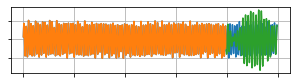

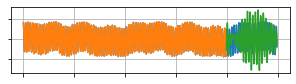

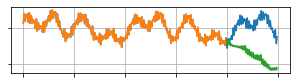

In [39]:
plot_trajectories(x,x_train,x_sim,r)